# Module importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import cv2 as cv

import h5py
import pickle
import os
import glob

# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.datafolders as df
import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.sebastien.set_graphs as set_graphs
import icewave.tools.Fourier_tools as FT

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

Windows
DESKTOP-N65FJTM


# Define fig_folder and parameters for plot

In [2]:
fig_folder = 'C:/Users/sebas/OneDrive/Bureau/These PMMH/Conferences/GDR_Geofluides_2025/Figures/'

font_size_medium = 40
font_size_small = round(0.75*font_size_medium)
plt.rc('font', size=font_size_medium)          # controls default text sizes
plt.rc('axes', titlesize=font_size_medium)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size_medium)    # legend fontsize
plt.rc('figure', titlesize=font_size_medium)  # fontsize of the figure title

fig_size = (12,9)
img_quality = 100 # dpi to save images 
marker_size_plot = 12

# Field Data BicWin 2024

### Collect data from a movie

In [3]:
date = '0226'
drone_ID = 'mesange'
exp_ID = '10-waves_005'
suffixe = f'{date}_{drone_ID}_{exp_ID}'

main_path = df.find_path(disk = 'Elements',year = '2024')
path2data = f'{main_path}{date}/Drones/{drone_ID}/matData/{exp_ID}/'

# search all _scaled.mat file 
filelist = glob.glob(path2data + '*_scaled.mat')
file2load = filelist[0]

# load file 
with h5py.File(file2load, 'r') as fmat:
            S = {}
            
            print('Top-level keys : ', list(fmat.keys()))
        
            S = mat2py.mat_to_dict(fmat['m'],fmat['m'])
            S = mat2py.transpose_PIVmat_fields(S)

ostype : Windows
Top-level keys :  ['#refs#', '#subsystem#', 'm']


### Collect associated picture

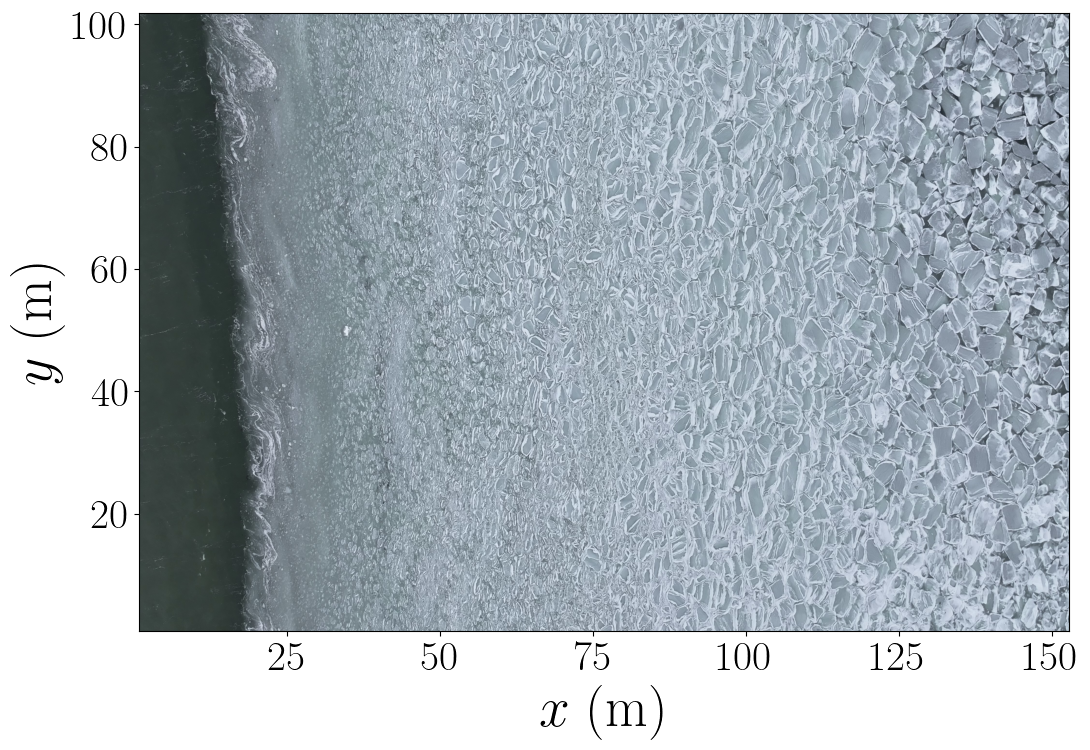

In [93]:
path2img = f'{main_path}{date}/Drones/{drone_ID}/{exp_ID}/'
filelist = glob.glob(path2img + '*_exemple.tiff')
img2load = filelist[0]

img = cv.imread(img2load)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
img = np.flip(img,axis = 0)

fig, ax = plt.subplots(figsize = fig_size)
ax.imshow(img,aspect = 'equal',origin = 'lower', extent = [S['x'][0],S['x'][-1],S['y'][0],S['y'][-1]])
ax.set_xlabel(r'$x \; \mathrm{(m)}$',labelpad = 5)
ax.set_ylabel(r'$y \; \mathrm{(m)}$',labelpad = 5)

figname = f'{fig_folder}example_MIZ_scaled_{date}_{drone_ID}_{exp_ID}'
plt.savefig(f'{figname}.png', bbox_inches = 'tight')
plt.savefig(f'{figname}.pdf', bbox_inches = 'tight')

### Get rid off quadratic field

In [4]:
Vs = FT.supress_quadratic_noise(np.transpose(S['Vx'],(1,0,2)), S['x'], S['y'])
Vs = np.transpose(Vs,(1,0,2))

Supressing quadratic noise...
Quadratic noise supressed


### Plot raw wavefield 

In [5]:
def show_velocity_field(V,x,y,colormap):

    field = V.T

    fig, ax = plt.subplots(figsize = (12,9))
    c = ax.imshow(field, cmap = colormap, aspect = 'equal', norm = 'linear', origin = 'lower',interpolation = 'gaussian',
                  extent = (x.min(),x.max(),y.min(),y.max()))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    
    cbar = plt.colorbar(c,cax = cax)
    cbar.set_label(r'$V_x (x,y) \; \mathrm{(m.s^{-1})}$',labelpad = 5)
    ax.set_xlabel(r'$x \; \mathrm{(m)}$', labelpad = 5)
    ax.set_ylabel(r'$y \; \mathrm{(m)}$', labelpad = 5)

    return fig, ax, cbar

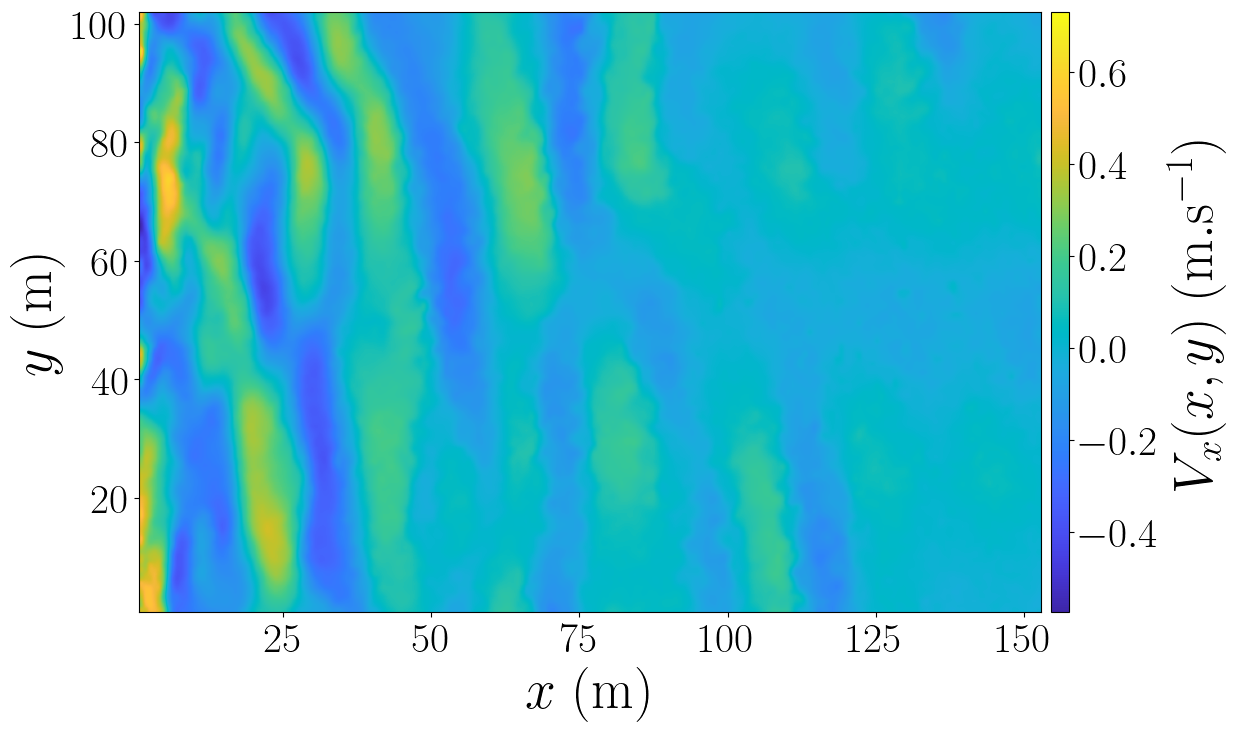

In [91]:

frame = 0
fig, ax ,cbar = show_velocity_field(Vs[:,:,frame],S['x'],S['y'],parula_map)

figname = f'{fig_folder}Vx_{suffixe}_frame_{frame:.1f}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

### Compute FFT spectrum

In [6]:
TF_spectrum,freq,FFT_t = FT.temporal_FFT(Vs,S['SCALE']['facq_t'],padding_bool = 1,add_pow2 = 0,output_FFT = True)

# save data in a structure
FFT_spectrum = {}
FFT_spectrum['TF_spectrum'] = TF_spectrum
FFT_spectrum['f'] = freq

Padding used


### Plot spectrum 

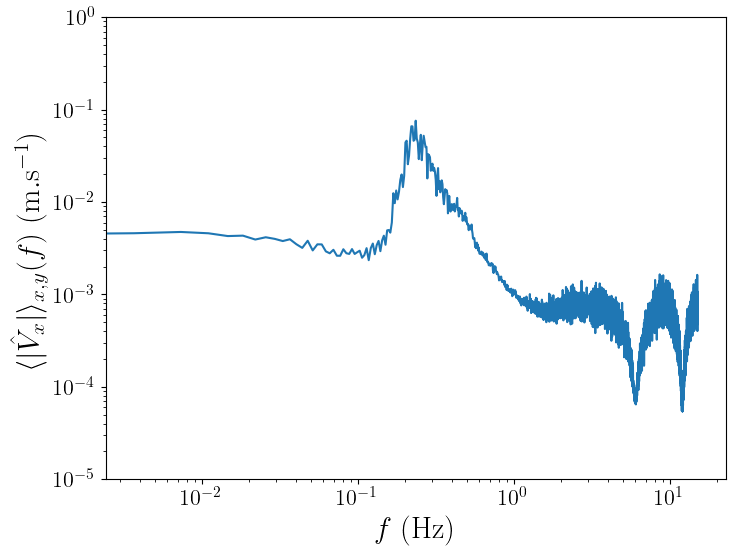

In [65]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()
ax.plot(freq,TF_spectrum)
ax.set_xlabel(r'$f \; \mathrm{(Hz)}$',labelpad = 5)
ax.set_ylabel(r'$\langle |\hat{V}_x| \rangle _{x,y}(f) \; \mathrm{(m.s^{-1})}$',labelpad = 5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim([1e-5,1e0])

figname = f'{fig_folder}TF_spectrum_{suffixe}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.svg', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

### Plot filtered wavefield

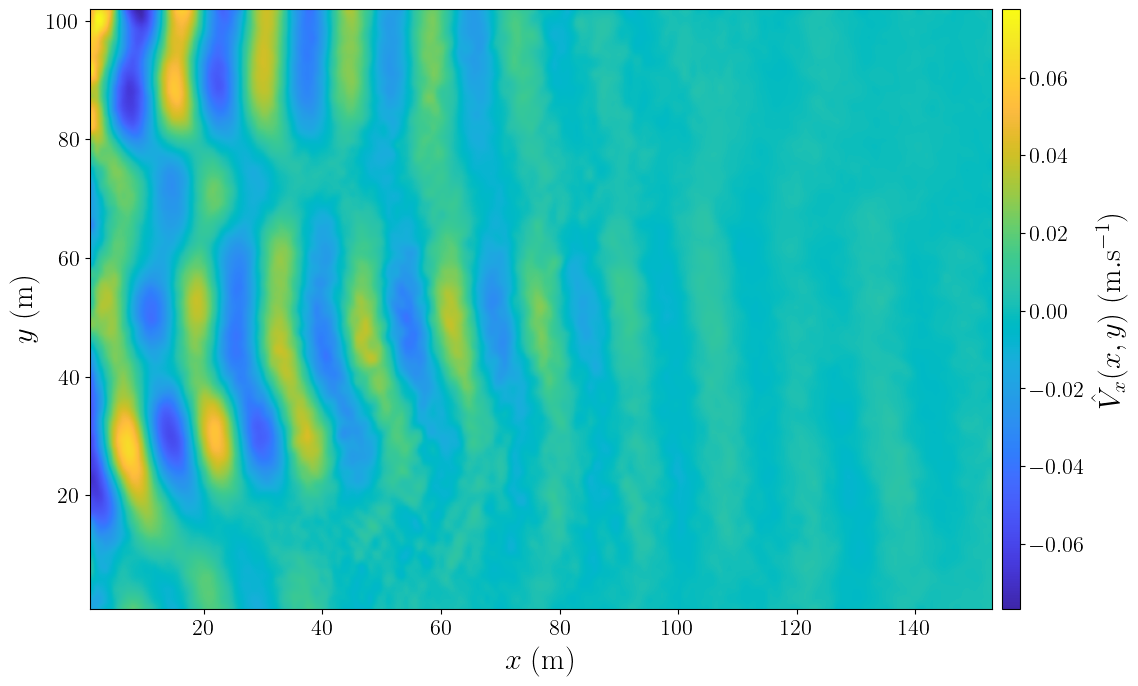

In [21]:
selected_freq = 0.33 # in Hz
idx_freq = np.argmin(abs(FFT_spectrum['f'] - selected_freq))
resulting_freq = FFT_spectrum['f'][idx_freq]

demod_field = FFT_t[:,:,idx_freq]
fig,ax,cbar = show_velocity_field(np.real(demod_field),S['x'],S['y'],parula_map)
cbar.set_label(r'$\hat{V}_x (x,y) \; \mathrm{(m.s^{-1})}$',labelpad = 5) 

# figname = f'{fig_folder}Vx_demod_{suffixe}_freq_{resulting_freq:.2f}'
# plt.savefig(figname + '.pdf', bbox_inches='tight')
# plt.savefig(figname + '.png', bbox_inches='tight')

### Show exponential fit 

In [22]:
def exponential_decay(x,A,alpha):
    y = A*np.exp(-alpha*x)
    return y

def exponential_fit(y,x,bounds = None):
    """ Perform exponential fit of data """
    if bounds is not None:
        popt,pcov = scipy.optimize.curve_fit(lambda x,A,alpha : exponential_decay(x,A,alpha),x,y,bounds = bounds)
    else:
        popt,pcov = scipy.optimize.curve_fit(lambda x,A,alpha : exponential_decay(x,A,alpha),x,y)
    err_coeff = np.sqrt(np.diag(pcov))

    return popt,err_coeff

#### Plot Exponential attenuation along a profile 

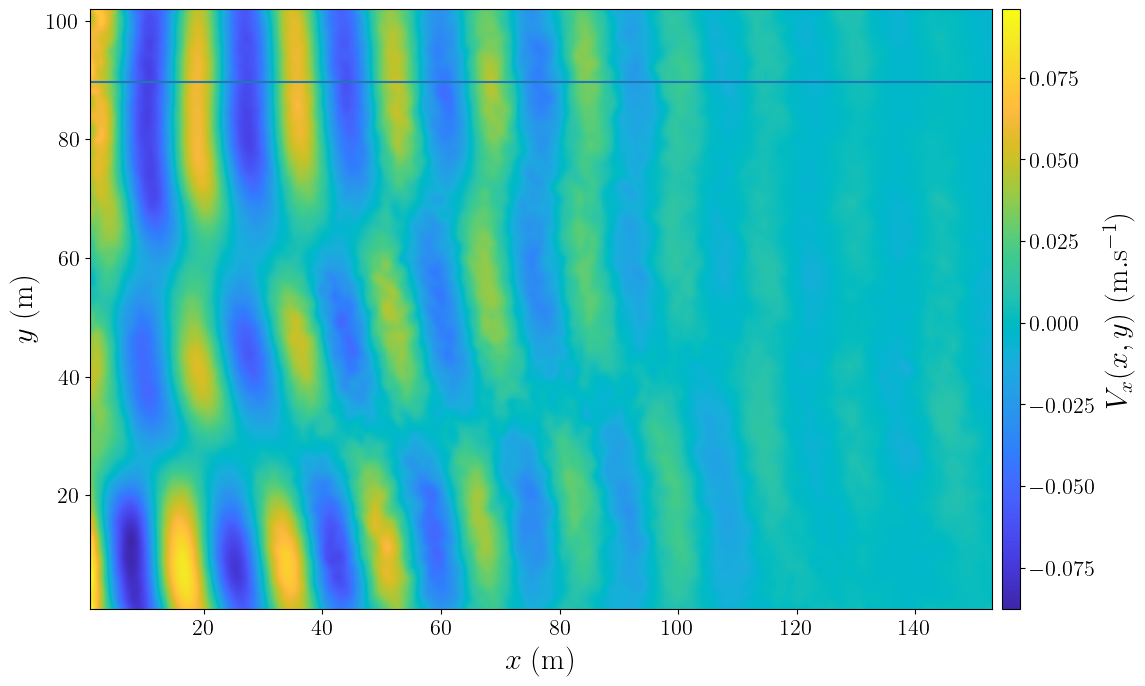

In [12]:
# select y coordinate for which we want to select profile 
y_selected = 90
idx_y = np.argmin(abs(y_selected - S['y']))

# check on the field 
fig, ax, cbar = show_velocity_field(np.real(demod_field),S['x'],S['y'],parula_map)
ax.axhline(S['y'][idx_y])

[0.08387149 0.01329652]


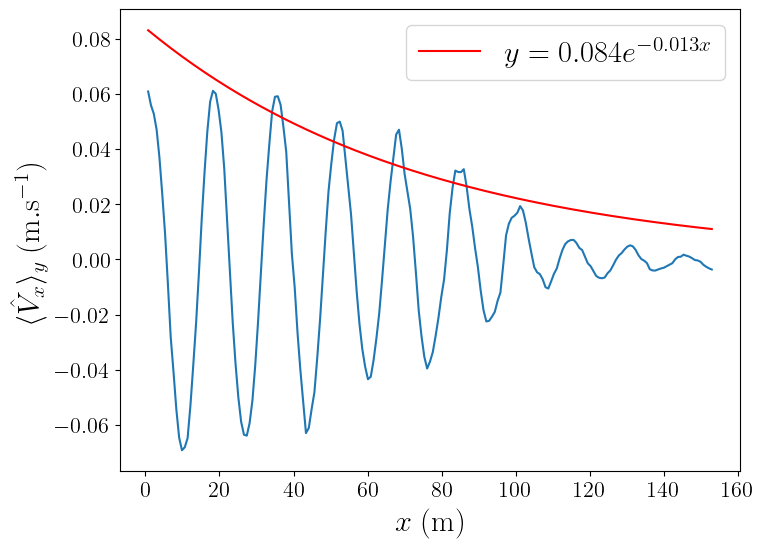

In [13]:
profile = demod_field[:,idx_y]

bounds = ([1e-4,1e-4],[1e0,1e0])
popt_exp,err_coeff_exp = exponential_fit(abs(profile),S['x'])

print(popt_exp)

xth = np.linspace(S['x'].min(),S['x'].max(),200)
yth = exponential_decay(xth,popt_exp[0],popt_exp[1])
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()
ax.plot(S['x'],np.real(profile))

label_th = r'$ y = ' + f'{popt_exp[0]:.3f}' + r'e^{-' + f'{popt_exp[1]:.3f}' + r'x}$'

ax.plot(xth,yth,'r',label = label_th)

ax.set_xlabel(r'$x \; \mathrm{(m)}$',labelpad = 5)
ax.set_ylabel(r'$\langle \hat{V}_x \rangle_{y} \; \mathrm{(m.s^{-1})}$',labelpad = 5)
ax.legend()

#### Plot Exponential attenuation after average

[0.01335778 0.01138418]


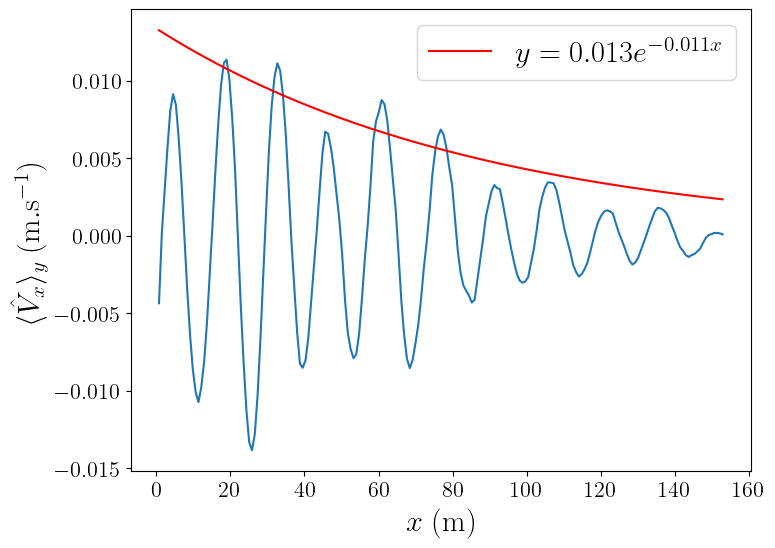

In [23]:
profile = np.mean(demod_field,1)

bounds = ([1e-4,1e-4],[1e0,1e0])
popt_exp,err_coeff_exp = exponential_fit(abs(profile),S['x'])

print(popt_exp)

xth = np.linspace(S['x'].min(),S['x'].max(),200)
yth = exponential_decay(xth,popt_exp[0],popt_exp[1])
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()
ax.plot(S['x'],np.real(profile))

label_th = r'$ y = ' + f'{popt_exp[0]:.3f}' + r'e^{-' + f'{popt_exp[1]:.3f}' + r'x}$'

ax.plot(xth,yth,'r',label = label_th)

ax.set_xlabel(r'$x \; \mathrm{(m)}$',labelpad = 5)
ax.set_ylabel(r'$\langle \hat{V}_x \rangle_{y} \; \mathrm{(m.s^{-1})}$',labelpad = 5)
ax.legend()

figname_exp = f'{fig_folder}Exponential_fit_{suffixe}_freq_{resulting_freq:.2f}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')




In [50]:
print(Vs.shape)

(134, 201, 5417)


In [16]:
print(S.keys())

dict_keys(['DRONE', 'GPS', 'ID', 'PIV_param', 'PIXEL', 'SCALE', 'UTC_t', 'Vx', 'Vy', 'Vz', 'X', 'Y', 'name', 't', 't0_UTC', 'units', 'x', 'xref', 'y', 'yref'])
